# Proyek Predictive Analytics: Customer Churn Prediction

Proyek ini bertujuan untuk memprediksi pelanggan yang kemungkinan churn (meninggalkan layanan) pada perusahaan telekomunikasi menggunakan machine learning. Proses prediksi ini akan membantu perusahaan dalam mengembangkan strategi untuk mengurangi churn pelanggan. Dataset yang digunakan berisi data pelanggan yang bisa diakses dari Kaggle, yang meliputi beberapa kolom seperti ID pelanggan, layanan yang digunakan, dan informasi demografis.

Dataset yang digunakan dalam proyek ini diambil dari Kaggle. Dataset ini berisi informasi tentang pelanggan dan layanan yang mereka gunakan.

##1. Data Understanding
Informasi Dataset
- Ukuran Dataset: 7,043 baris dan 21 kolom
- Link Sumber Dataset: [Kaggle Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

Dataset ini berisi kolom-kolom berikut:
- **customerID**: ID unik pelanggan
- **gender**: Jenis kelamin pelanggan
- **SeniorCitizen**: Indikator apakah pelanggan adalah orang tua
- **Partner**: Apakah pelanggan memiliki pasangan
- **Dependents**: Apakah pelanggan memiliki tanggungan
- **tenure**: Lama waktu pelanggan menggunakan layanan
- **PhoneService**: Apakah pelanggan memiliki layanan telepon
- **MultipleLines**: Apakah pelanggan memiliki beberapa sambungan telepon
- **InternetService**: Jenis layanan internet yang digunakan
- **OnlineSecurity, DeviceProtection, TechSupport, StreamingTV, StreamingMovies**: Layanan tambahan yang dimiliki
- **Contract**: Tipe kontrak (bulan ke bulan, satu tahun, dua tahun)
- **PaperlessBilling**: Apakah pelanggan menggunakan penagihan tanpa kertas
- **PaymentMethod**: Metode pembayaran
- **MonthlyCharges**: Biaya bulanan
- **TotalCharges**: Total biaya yang dibayarkan
- **Churn**: Apakah pelanggan meninggalkan layanan (ya/tidak)

##2. Data Preprocessing
Tahap ini meliputi:
1. Import libraries yang akan digunakan pada proyek ini
2. Memuat dataset.
3. Memeriksa informasi awal seperti jumlah baris dan kolom, nilai yang hilang, dan tipe data.
4. Menampilkan distribusi churn pelanggan untuk memperoleh gambaran dasar.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Memeriksa Informasi Dataset

Menampilkan informasi umum tentang dataset untuk memastikan tidak ada data yang hilang dan mengidentifikasi tipe data.

In [3]:
# Memeriksa informasi awal dari dataset
print("Informasi Dataset:")
print(df.info())
print("\nStatistik Deskriptif:")
print(df.describe())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

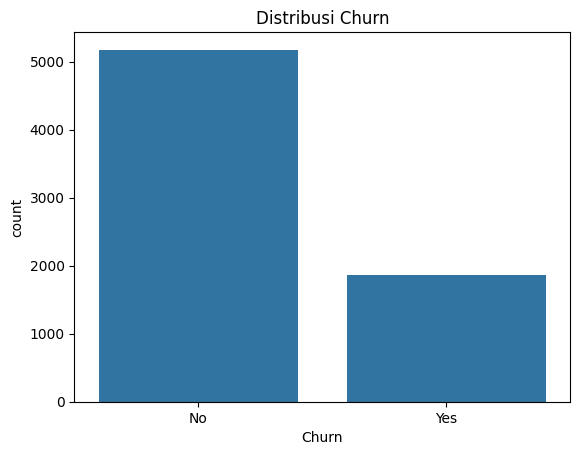

In [4]:
# Visualisasi distribusi churn
sns.countplot(x='Churn', data=df)
plt.title('Distribusi Churn')
plt.show()

##3. Data Preparation
Sebelum membangun model, tahap ini meliputi:
1. Menangani nilai hilang dengan menggantinya menggunakan median.
2. Menangani outlier pada kolom `MonthlyCharges` dengan metode IQR.
3. Preprocessing data numerik menggunakan `StandardScaler` dan kategorikal menggunakan `OneHotEncoder`.
4. Memisahkan data menjadi fitur (X) dan label (y), serta
5. Membagi dataset menjadi data pelatihan dan pengujian.

In [5]:
# Mengubah kolom `TotalCharges` menjadi numerik dan mengisi missing values dengan median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

<ipython-input-5-f28a785c6855>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [6]:
# Menangani outlier pada kolom `MonthlyCharges` dengan metode IQR
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

In [7]:
# Mendefinisikan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [8]:
# Mengganti nilai outlier pada `MonthlyCharges` dengan batas atas/bawah
df['MonthlyCharges'] = np.where(df['MonthlyCharges'] < lower_bound, lower_bound, df['MonthlyCharges'])
df['MonthlyCharges'] = np.where(df['MonthlyCharges'] > upper_bound, upper_bound, df['MonthlyCharges'])

In [9]:
# Visualisasi boxplot sebelum dan sesudah penanganan outlier
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Boxplot of MonthlyCharges (Sebelum penanganan outliers)')

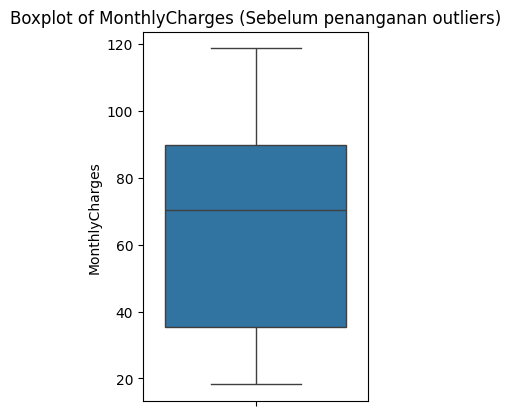

In [10]:
# Boxplot sebelum penanganan outlier
plt.subplot(1, 2, 1)
sns.boxplot(y=df['MonthlyCharges'])
plt.title('Boxplot of MonthlyCharges (Sebelum penanganan outliers)')

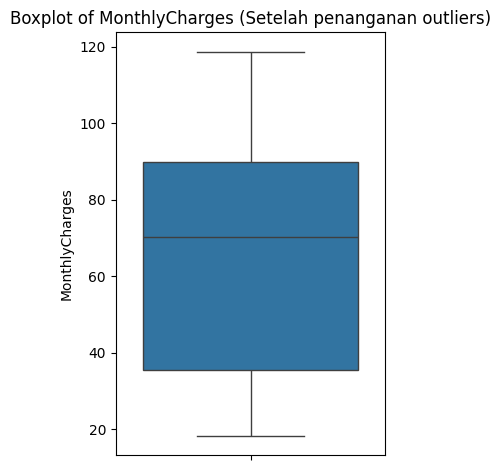

In [11]:
# Boxplot setelah penanganan outlier
plt.subplot(1, 2, 2)
sns.boxplot(y=df['MonthlyCharges'])
plt.title('Boxplot of MonthlyCharges (Setelah penanganan outliers)')

plt.tight_layout()
plt.show()

In [12]:
# Visualisasi distribusi sebelum dan sesudah penanganan outlier
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Distribusi MonthlyCharges (Sebelum penanganan outliers)')

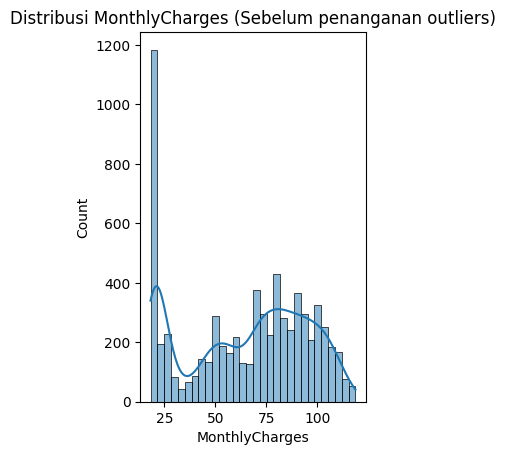

In [13]:
# Histogram sebelum penanganan outlier
plt.subplot(1, 2, 1)
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('Distribusi MonthlyCharges (Sebelum penanganan outliers)')

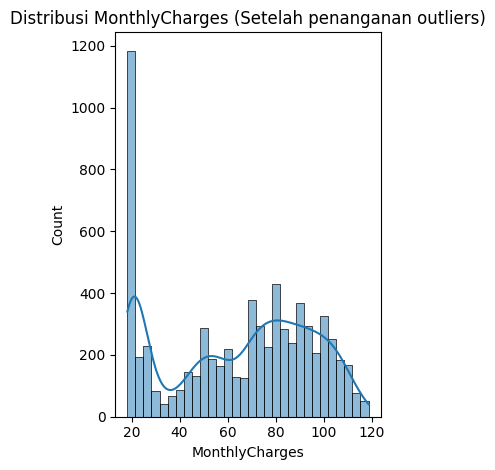

In [14]:
# Histogram setelah penanganan outlier
plt.subplot(1, 2, 2)
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('Distribusi MonthlyCharges (Setelah penanganan outliers)')

plt.tight_layout()
plt.show()

In [15]:
# Memisahkan fitur dan target
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [16]:
# Menentukan kolom kategorikal dan numerik
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']

In [17]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [18]:
# Preprocessing menggunakan StandardScaler untuk numerik dan OneHotEncoder untuk kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##4. Modelling dan Evaluasi
## Modelling dan Evaluasi

Pada tahap ini akan menerapkan beberapa algoritma machine learning untuk memprediksi churn pelanggan. Algoritma machine learning yang digunakan yaitu:

- **Logistic Regression**
- **Random Forest**
- **XGBoost**

Setiap model akan dilatih dan dievaluasi menggunakan data pengujian untuk menentukan akurasinya.


In [20]:
# Logistic Regression
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(max_iter=200))])

model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8211497515968772
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



### Logistic Regression

*   Akurasi: 82.11%
*   Precision untuk kelas 0 (tidak churn): 0.86, dan untuk kelas 1 (churn): 0.69.
*   Recall untuk kelas 0: 0.90, dan untuk kelas 1: 0.60.
*   F1-score untuk kelas 1: 0.64.



Model ini cukup baik dalam mengklasifikasikan pelanggan yang tidak churn (kelas 0) dengan akurasi yang tinggi. Namun, performa untuk mengidentifikasi pelanggan yang churn (kelas 1) kurang baik, terlihat dari recall dan F1-score yang lebih rendah. Hal ini menunjukkan bahwa model mungkin tidak cukup sensitif dalam mendeteksi pelanggan yang berisiko meninggalkan layanan.

In [21]:
# Random Forest
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))])

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8048261178140526
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.68      0.50      0.58       373

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



### Random Forest

* Akurasi: 80.48%
* Precision untuk kelas 0: 0.84, dan untuk kelas 1: 0.68.
* Recall untuk kelas 0: 0.91, dan untuk kelas 1: 0.50.
* F1-score untuk kelas 1: 0.58.

Random Forest menunjukkan akurasi yang sedikit lebih rendah dibandingkan Logistic Regression. Meskipun model ini berhasil mengklasifikasikan pelanggan yang tidak churn dengan baik, tetapi kurang efektif dalam mengidentifikasi churn. Recall untuk kelas 1 sangat rendah (0.50), menunjukkan bahwa banyak pelanggan yang churn tidak terdeteksi.

In [22]:
# XGBoost
model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("\n=== XGBoost ===")
print("Akurasi:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost ===
Akurasi: 0.8041163946061036
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.66      0.54      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:55:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### XGBoost

* Akurasi: 80.41%
* Precision untuk kelas 0: 0.84, dan untuk kelas 1: 0.66.
* Recall untuk kelas 0: 0.90, dan untuk kelas 1: 0.54.
* F1-score untuk kelas 1: 0.59.

Hasil XGBoost mirip dengan Random Forest dengan akurasi yang sedikit lebih rendah. Performa di kelas 1 juga menunjukkan bahwa model ini tidak cukup efektif dalam mengidentifikasi churn.

In [23]:
# Hyperparameter tuning untuk XGBoost
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(model_xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Accuracy for XGBoost:", grid_search_xgb.best_score_)

Best Parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best Accuracy for XGBoost: 0.8028044018459354


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameter tuning yang telah dilakukan untuk mengoptimalkan kinerja model XGBoost, menghasilkan parameter terbaik sebagai berikut:

- Learning rate: 0.1
- Max depth: 3
- Number of estimators: 50

Meskipun tuning ini memberikan peningkatan akurasi yang kecil, tetap menunjukkan bahwa model ini mirip dengan performa Random Forest, tetapi dengan akurasi yang sedikit lebih rendah. Namun, tantangan utama yang dihadapi adalah efektivitas model dalam mengidentifikasi churn pelanggan, terutama pada kelas 1, di mana recall dan precision masih perlu ditingkatkan.

### Confusion Matrix

Berikut adalah Confusion Matrix untuk setiap model untuk menggambarkan performa prediksi churn pelanggan:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**

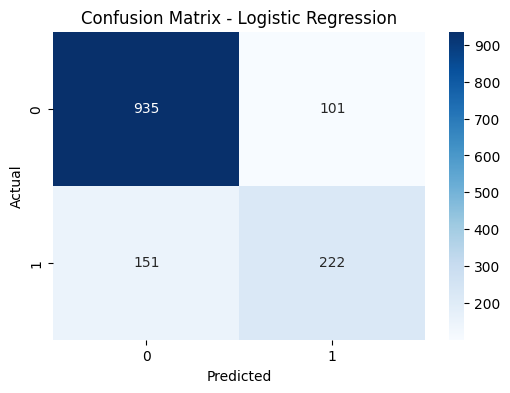

In [24]:
# Confusion Matrix untuk Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

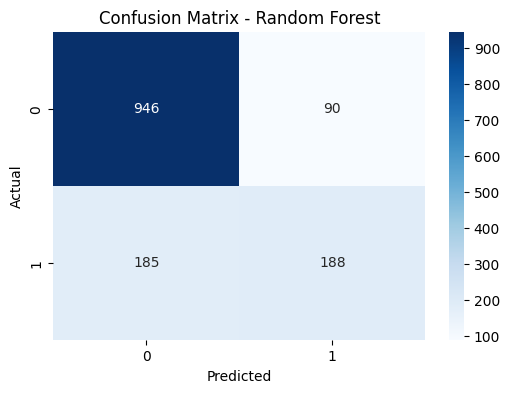

In [25]:
# Confusion Matrix untuk Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

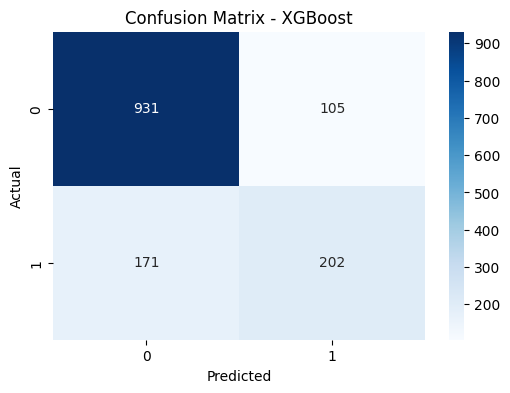

In [26]:
# Confusion Matrix untuk XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()